In [141]:
from __future__ import division, print_function, absolute_import

%matplotlib inline
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
from scipy import misc
import skimage
from skimage import transform, io
from functools import reduce
import scipy
from itertools import product
from keras import models, layers
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import keras
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import tqdm
import fnmatch

In [2]:
train_dir = './dataset/probav_data/train/'
test_dir = './dataset/probav_data/test/'
red_train = os.path.join(train_dir, 'RED')
nir_train = os.path.join(train_dir, 'NIR')
red_test = os.path.join(test_dir, 'RED')
nir_test = os.path.join(test_dir, 'NIR')
print("train set: {} RED {} NIR = {} Total".format(len(os.listdir(red_train)),
                                                   len(os.listdir(nir_train)),
                                                   len(os.listdir(red_train))+ len(os.listdir(nir_train))))
print("test set: {} RED {} NIR = {} Total".format(len(os.listdir(red_test)),
                                                   len(os.listdir(nir_test)),
                                                   len(os.listdir(red_test))+ len(os.listdir(nir_test))))
os.listdir(red_train)[:10]

train set: 594 RED 566 NIR = 1160 Total
test set: 146 RED 144 NIR = 290 Total


['imgset0323',
 'imgset0338',
 'imgset0257',
 'imgset0373',
 'imgset0286',
 'imgset0339',
 'imgset0164',
 'imgset0026',
 'imgset0335',
 'imgset0054']

In [3]:
sorted(os.listdir(os.path.join(red_train, 'imgset0323')))

['HR.png',
 'LR000.png',
 'LR001.png',
 'LR002.png',
 'LR003.png',
 'LR004.png',
 'LR005.png',
 'LR006.png',
 'LR007.png',
 'LR008.png',
 'LR009.png',
 'LR010.png',
 'LR011.png',
 'LR012.png',
 'LR013.png',
 'LR014.png',
 'LR015.png',
 'LR016.png',
 'LR017.png',
 'LR018.png',
 'LR019.png',
 'QM000.png',
 'QM001.png',
 'QM002.png',
 'QM003.png',
 'QM004.png',
 'QM005.png',
 'QM006.png',
 'QM007.png',
 'QM008.png',
 'QM009.png',
 'QM010.png',
 'QM011.png',
 'QM012.png',
 'QM013.png',
 'QM014.png',
 'QM015.png',
 'QM016.png',
 'QM017.png',
 'QM018.png',
 'QM019.png',
 'SM.png']

we have two folders, training data and testing data, each one has two folders, one contains the NIR images and the other contains the RED images.<br>
In the training set, for each scene we have one high resolution image (which we need to construct) and several low resolution images. for each image we have a status map that indicates the clear pixels<br>


so let's take a look at the data

In [4]:
image = io.imread(os.path.join(red_train, 'imgset0323', 'HR.png'))
print(image.dtype, image.shape)

uint16 (384, 384)


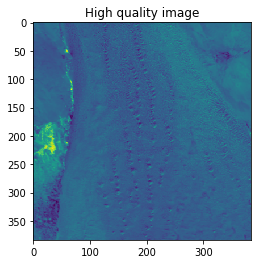

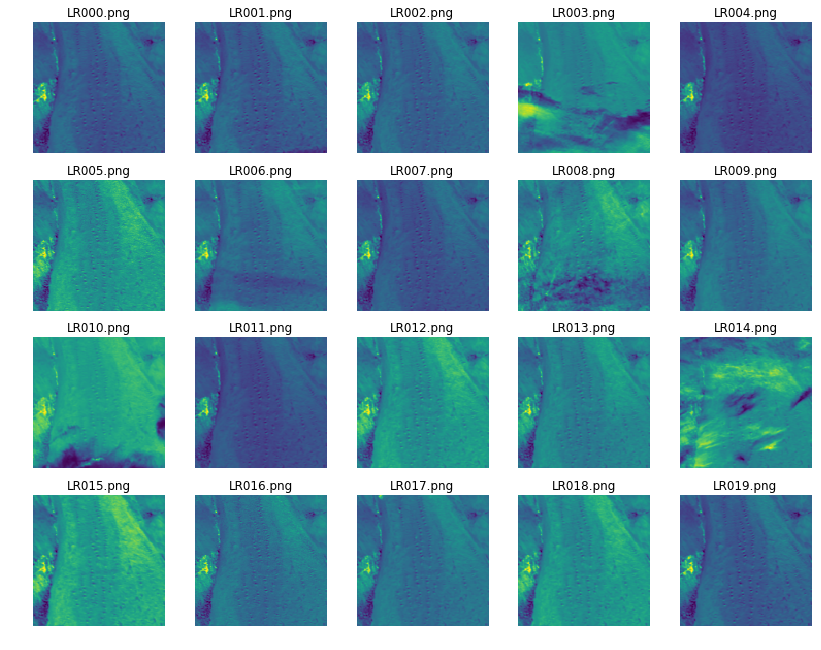

In [5]:
example = 'imgset0323'
hr = io.imread(os.path.join(red_train, example, 'HR.png'))
plt.imshow(hr)
plt.title("High quality image")
fig = plt.figure(figsize=(14, 14))
num_image = len(glob(os.path.join(red_train, example) + '/LR*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/LR*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])

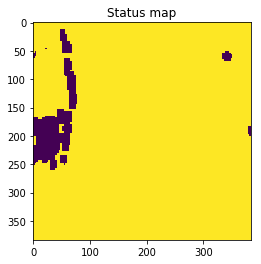

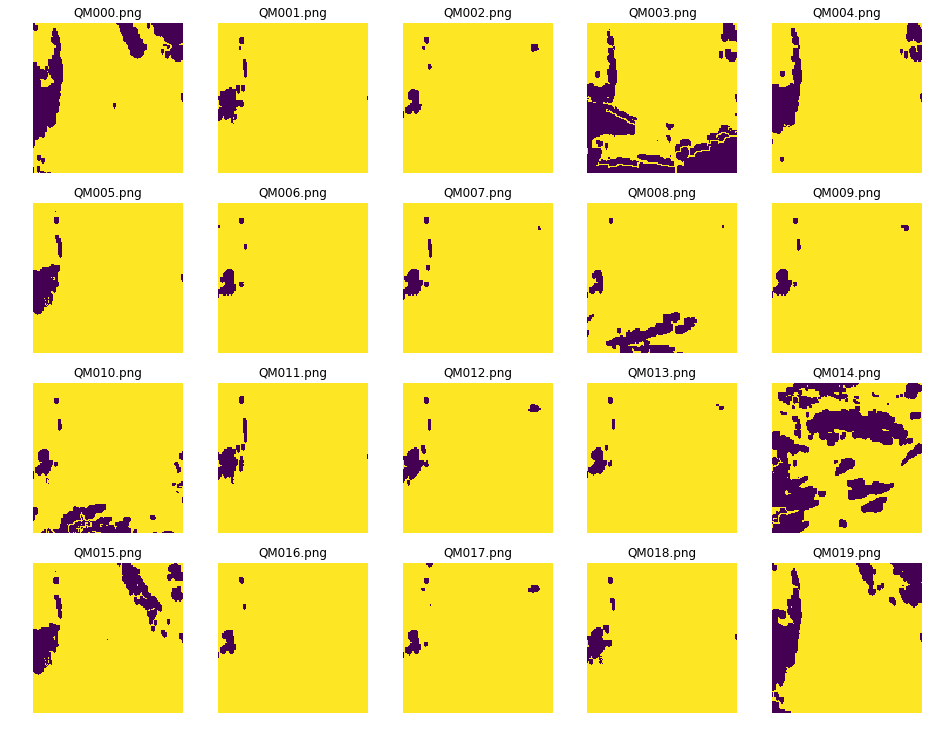

In [6]:
sm = io.imread(os.path.join(red_train, example, 'SM.png'))
plt.imshow(sm)
plt.title("Status map")
fig = plt.figure(figsize=(16, 16))
num_image = len(glob(os.path.join(red_train, example) + '/QM*.png'))
for i, im in enumerate(sorted(glob(os.path.join(red_train, example) + '/QM*.png'))):
    image = io.imread(im)
    ax = fig.add_subplot(num_image/5+1, 5, i+1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(im.split('/')[-1])
    

In [7]:
norm = pd.read_csv("./dataset/probav_data/norm.csv", names=['file name', 'PSNR'], sep= ' ')
norm.head()

file name       PSNR
0  imgset0000  52.352173
1  imgset0001  46.464812
2  imgset0002  48.646021
3  imgset0003  45.709971
4  imgset0004  52.947346

In [8]:
norm.shape

(1450, 2)

Let's write some helper function to display and compare images

In [9]:
def get_data(path):
    """list all image path in a folder (train or test)"""
    listing = [os.path.join(path, i, j) for i in ['RED', 'NIR'] for j in os.listdir(os.path.join(path, i))]
    return sorted(listing, key=lambda x: x[-4:])

In [10]:
train = get_data(train_dir)
test = get_data(test_dir)
train[:6]

['./dataset/probav_data/train/RED/imgset0000',
 './dataset/probav_data/train/RED/imgset0001',
 './dataset/probav_data/train/RED/imgset0002',
 './dataset/probav_data/train/RED/imgset0003',
 './dataset/probav_data/train/RED/imgset0004',
 './dataset/probav_data/train/RED/imgset0005']

In [11]:
help(io.imread)

Help on function imread in module skimage.io._io:

imread(fname, as_gray=False, plugin=None, flatten=None, **plugin_args)
    Load an image from file.
    
    Parameters
    ----------
    fname : string
        Image file name, e.g. ``test.jpg`` or URL.
    as_gray : bool, optional
        If True, convert color images to gray-scale (64-bit floats).
        Images that are already in gray-scale format are not converted.
    plugin : str, optional
        Name of plugin to use.  By default, the different plugins are
        tried (starting with imageio) until a suitable
        candidate is found.  If not given and fname is a tiff file, the
        tifffile plugin will be used.
    
    Other Parameters
    ----------------
    plugin_args : keywords
        Passed to the given plugin.
    flatten : bool
        Backward compatible keyword, superseded by `as_gray`.
    
    Returns
    -------
    img_array : ndarray
        The different color bands/channels are stored in the
       

In [12]:
def get_hr(path):
    """get the high resolution image with its correspending status map
    """
    # to have value between 0 and 1
    hr = skimage.img_as_float64(io.imread(path + '/HR.png').astype(np.uint16))
    sm = io.imread(path + '/SM.png').astype(np.bool)
    return hr, sm

In [13]:
hr, sm = get_hr(train[3])

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


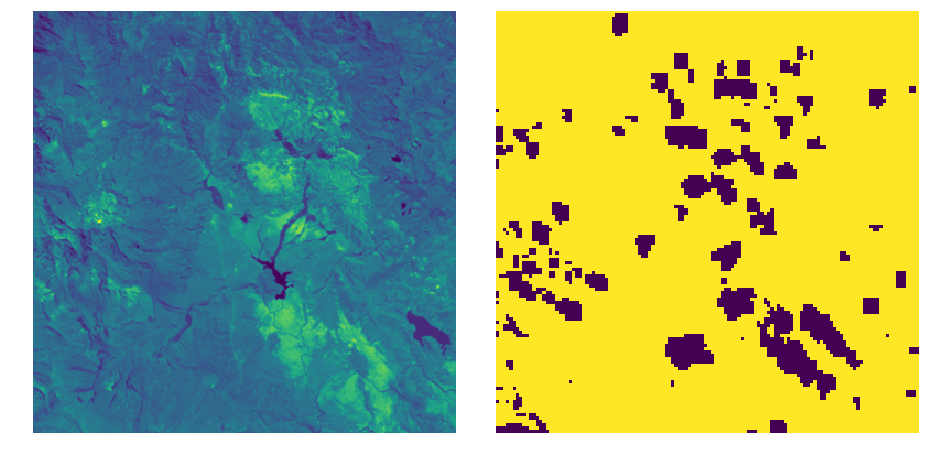

In [14]:
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(121).imshow(hr); plt.axis('off')
ax2 = fig.add_subplot(122).imshow(sm); plt.axis('off')
fig.tight_layout()
fig.show()

In [15]:
#hr2 = skimage.img_as_float64(hr)
sm

Image([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [16]:
def get_lr(path):
    """generator of low resolution, status map tuple 
    Parameters:
        path : path to the folder containing the images
    Returns:
        generator of a tuple of lr image and status map"""
    for file in glob(path+'/LR*.png'):
        lr = skimage.img_as_float64(io.imread(file).astype(np.uint16))
        QM = file.replace('LR', 'QM')
        qm = io.imread(QM).astype('bool')
        yield (lr, qm)

In [ ]:
def read_image(path):
    """generator of low resolution, status map tuple 
    Parameters:
        path : path to the folder containing the images
    Returns:
        generator of a tuple of lr image and status map"""
    for file in glob(path+'/LR*.png'):
        lr = skimage.img_as_float64(io.imread(file).astype(np.uint16))
        QM = file.replace('LR', 'QM')
        qm = io.imread(QM).astype('bool')
        yield (lr, qm)

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


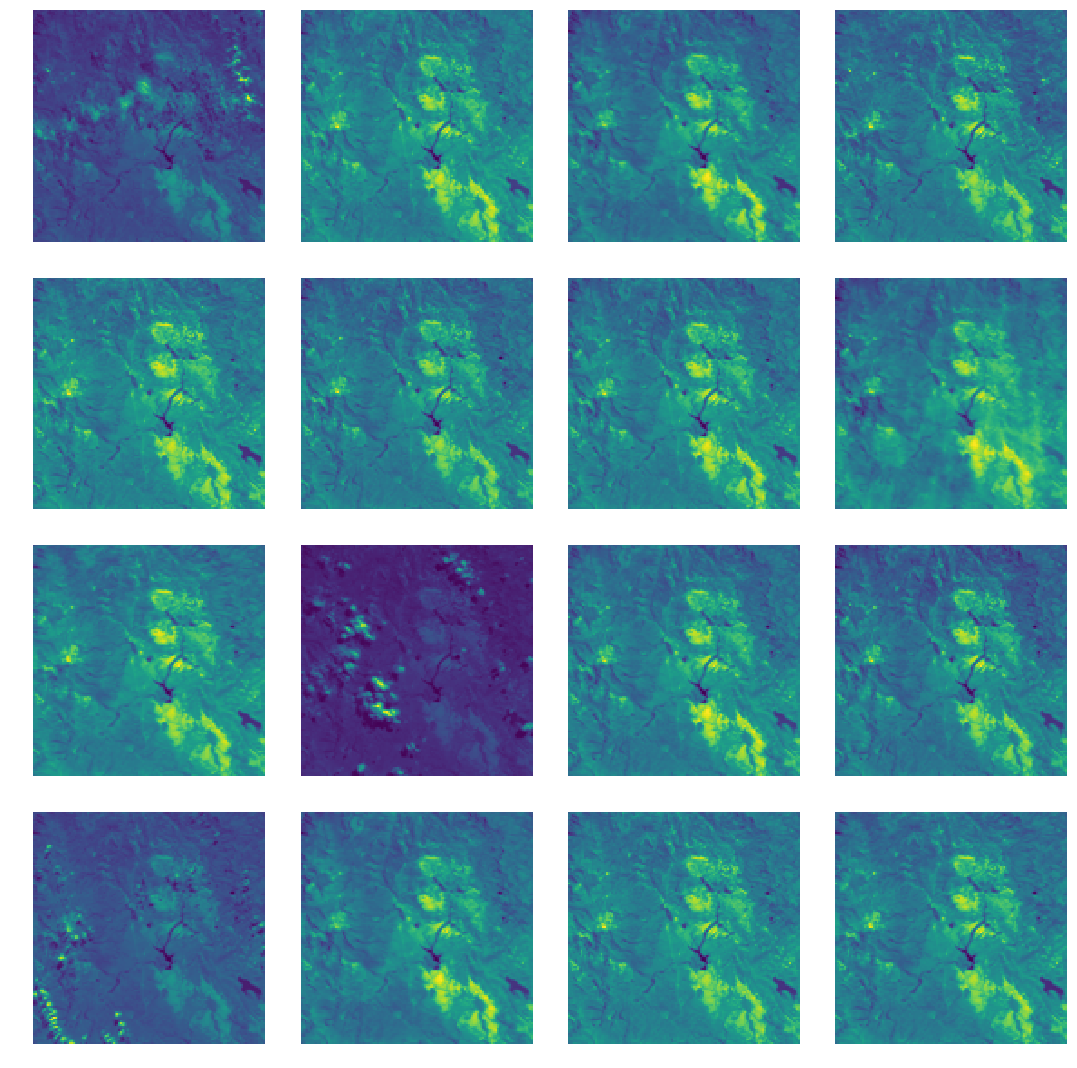

In [17]:
fig = plt.figure(figsize=(15, 15))
for i, (lr, sm) in enumerate(get_lr(train[3])):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(lr)
    plt.axis('off')
    if i == 15:
        break
fig.tight_layout()
fig.show()

The first approx that we will use (and also the simplest one), is we will try to construct the HR image by aggregating the LR images<br>
we have many option, for this aggregation, first the function to use to aggregate the pixels and whither to consider only the clear pixel or aggregate all pixels

In [18]:
def agg_image(path, agg_fc, use_sm = True):
    
    """combine the LR images by aggregate their pixels
    
    Parameters:
        path:path to the folder of the image
        agg_fc: function to use to aggregate pixels
                it can be any function that takes a list of numpy array as input
                and output a float for each element on axis 0
                this function should also hundle nan values
                example are np.nanmean, np.nanmax, np.nanmedian, scipy.stats.mode
        use_sm : a boolean parameter to choose whether to use status map or
                to include all pixels
    Returns:
        image with 384x384 resolution
    """
    
    lr_sm_list = list(get_lr(path))
    lr_list = []
    lr_nan = []
    for (lr, sm) in lr_sm_list:
        if use_sm:
            temp = lr.copy()
            temp[sm] = np.nan
            lr_nan.append(temp)
            lr[~sm] = np.nan
        lr_list.append(lr)
    scaled_img = agg_fc(lr_list, axis = 0)
    if use_sm:
        any_nan = np.isnan(lr_nan).any(axis=0)
        lr_nan= agg_fc(lr_nan, axis=0)
        lr_nan[any_nan] = 0.0
        np.nan_to_num(scaled_img, copy=False)
        scaled_img += lr_nan
    return scaled_img

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


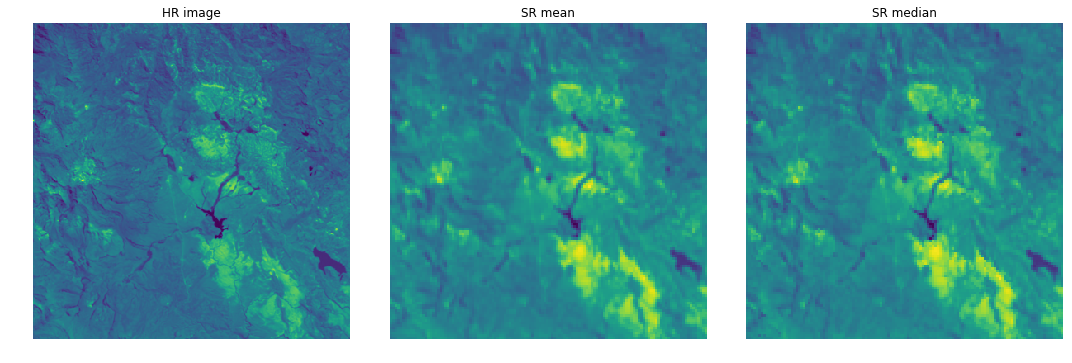

In [19]:
example = train[3]
hr_image,_ = get_hr(example)
sr_image = agg_image(example, np.nanmean, use_sm=False)
sr_image2 = agg_image(example, np.nanmedian, use_sm=True)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(132); ax.imshow(sr_image); ax.set_title('SR mean');plt.axis('off')
ax = fig.add_subplot(133); ax.imshow(sr_image2); ax.set_title('SR median');plt.axis('off')
fig.tight_layout()
fig.show()

In [20]:
# we will use a basic rescaling method which is the bicubic transformation
def bicubic_transform(lr, mode = 'reflect'):
    """funtion to perform the bicubic transformation
    using skimage library"""
    lr = transform.rescale(lr, scale=3, order=3, mode=mode)
    return lr

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


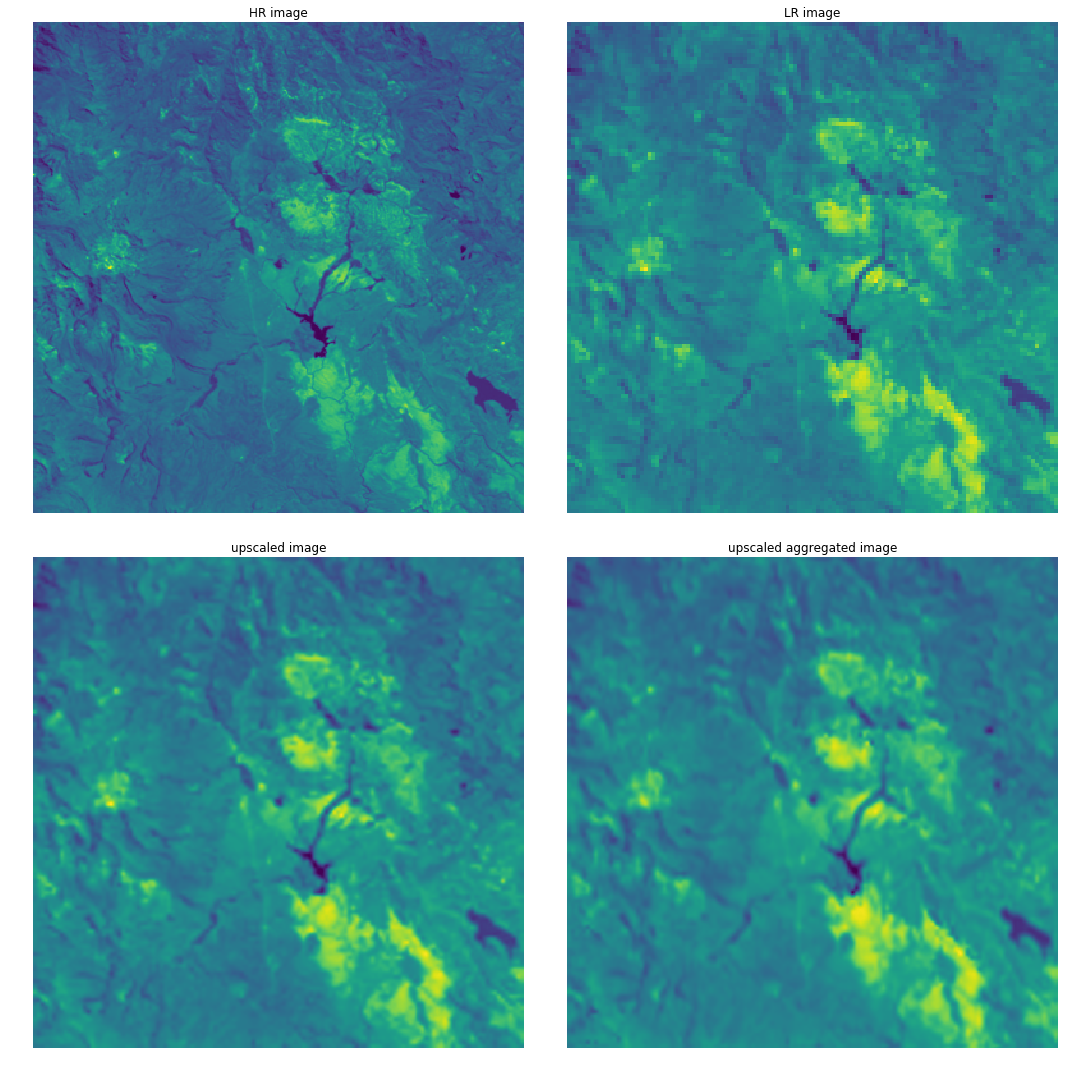

In [21]:
example = train[3]
hr_image,_ = get_hr(example)
lr_image, _ = list(get_lr(example))[1]
upscale_lr_image = bicubic_transform(lr_image, mode='symmetric')
sr_image = bicubic_transform(agg_image(example, np.nanmean, use_sm=True))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image); ax.set_title('HR image');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(lr_image); ax.set_title('LR image');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(upscale_lr_image); ax.set_title('upscaled image');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image); ax.set_title('upscaled aggregated image');plt.axis('off')
fig.tight_layout()
fig.show()

In [22]:
# in order to compare results, we will write a function 
# to calculate the cPSNR which is the used in th competition 

def cPSNR_image(image_path, sr, norm_path='./dataset/probav_data/norm.csv'):
    """function to calculate the clear peak signal to noise rate
    it is the metric used for proba_v conmpetition. This metric uses
    the norm.csv file that contains the baseline cPSNR of image HR"""
    # see https://kelvins.esa.int/proba-v-super-resolution/scoring/
    
    image_id = image_path[-10:]
    # read the file containing the baseline cPSNR
    norm = pd.read_csv(norm_path, sep=' ', names=['image', 'cPSNR'], index_col='image')
    # transform it to pandas Series
    norm = norm.T.squeeze()
    # we crop the HR image so we should also crop th SR image
    sr_crop = sr[3:-3, 3:-3]
    # list individual score of SR for each u, v in {0, 1, ... , 6}
    z = [] 
    hr, sm = get_hr(image_path)
    for u, v in product(range(7), range(7)):
        # crop the image so that its upper left corner at coordinates (u,v)
        # and its lower right corner at (378+u,378+v)
        hr_uv = hr[u:378+u, v:378+v]
        sm_uv = sm[u:378+u, v:378+v]
        b = np.mean(hr_uv[sm_uv] - sr_crop[sm_uv])
        cMSE = np.mean((hr_uv[sm_uv] - sr_crop[sm_uv]-b)**2)
        cPSNR = -10.*np.log10(cMSE)
        z.append(norm[image_id]/cPSNR)
    return np.min(z)        

In [23]:
def cPSNR_images(images_path, sr_images, norm_path = './dataset/probav_data/norm.csv'):
    
    """function to calculate the total score of a submission
    Parameters:
        images_path: list of paths to the HR images, it can be the train folder 
                    path or the test folder
        sr_images: an iterable that contain the SR images
        norm_path : path to the norm.csv file
    Returns:
        the mean score of all images in images_path
        """
    return  np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(images_path, sr_images)])

In [24]:
cPSNR_image(example, hr_image)

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


0.0

In [25]:
for i in range(5):
    example = train[i]
    sr_mean = bicubic_transform(agg_image(example, np.nanmean, use_sm=True))
    sr_median = bicubic_transform(agg_image(example, np.nanmedian, use_sm=True))
    print("image {}: PSNR for mean is {}".format(i, cPSNR_image(example, sr_mean)))
    print("image {}: PSNR for median is {}".format(i, cPSNR_image(example, sr_median)))

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


image 0: PSNR for mean is 1.0012534415035144
image 0: PSNR for median is 1.0009902378023554
image 1: PSNR for mean is 1.0012503017893777
image 1: PSNR for median is 0.9945207951685984
image 2: PSNR for mean is 1.0167743528564204
image 2: PSNR for median is 1.025069441141945


/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


image 3: PSNR for mean is 1.028289898578307
image 3: PSNR for median is 1.024679864271866
image 4: PSNR for mean is 0.9925904231766406
image 4: PSNR for median is 0.986730373613739


/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


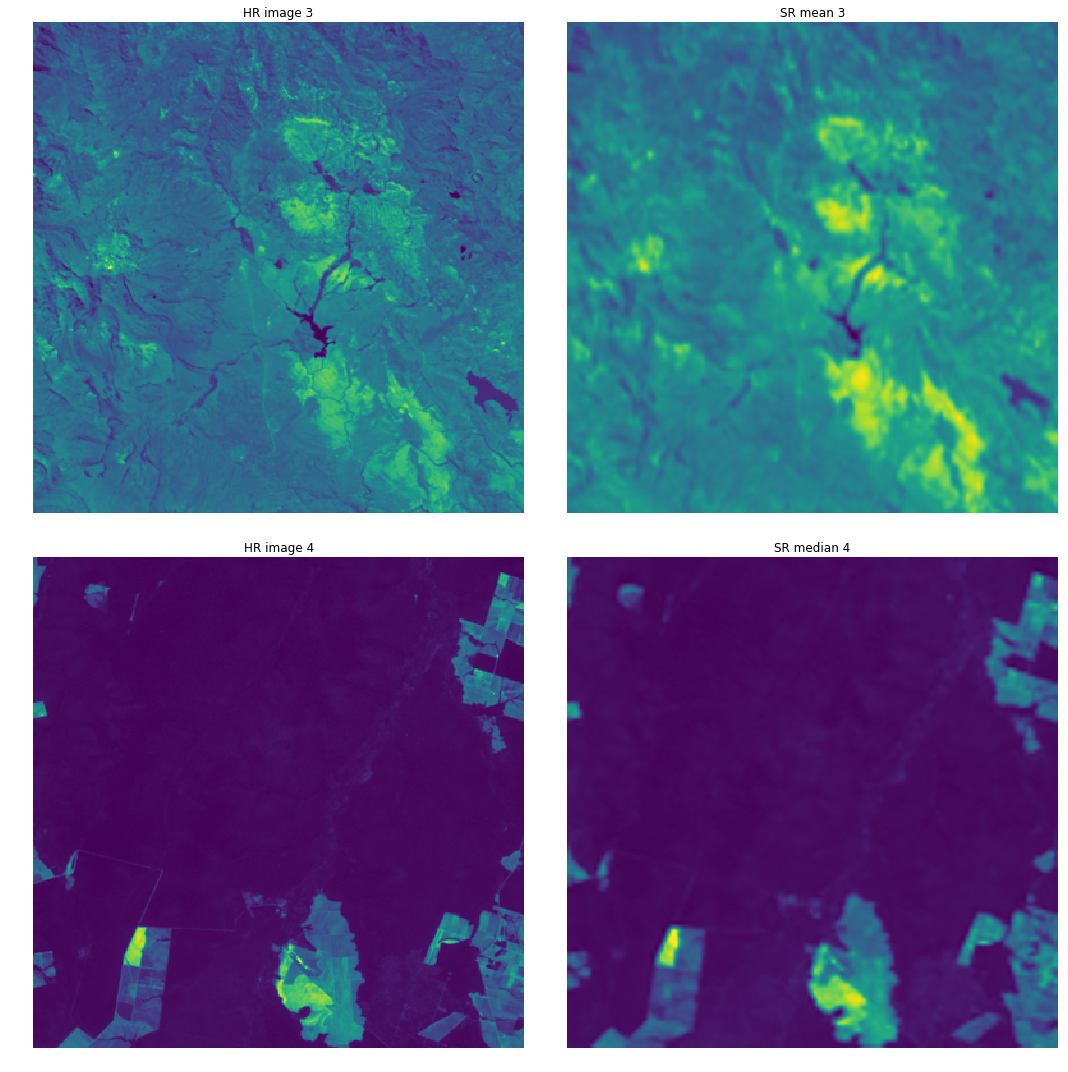

In [26]:
# a bad example compared to baseline
example1 = train[3]
hr_image1,_ = get_hr(example1)
sr_image1 = bicubic_transform(agg_image(example1, np.nanmean, use_sm=False))

# a good example compared to baseline
example2 = train[4]
hr_image2,_ = get_hr(example2)
sr_image2 = bicubic_transform(agg_image(example2, np.nanmedian, use_sm=True))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221); ax.imshow(hr_image1); ax.set_title('HR image 3');plt.axis('off')
ax = fig.add_subplot(222); ax.imshow(sr_image1); ax.set_title('SR mean 3');plt.axis('off')
ax = fig.add_subplot(223); ax.imshow(hr_image2); ax.set_title('HR image 4');plt.axis('off')
ax = fig.add_subplot(224); ax.imshow(sr_image2); ax.set_title('SR median 4');plt.axis('off')
fig.tight_layout()
fig.show()

In [27]:
%%time
# let's apply aggregation with median and upscale with bicubic transformnation
# and calculate the total score on the training set
sr_median_all = [bicubic_transform(agg_image(path_i, agg_fc=np.nanmedian)) for path_i in train]
total_score = np.mean([cPSNR_image(path_i, sr_i) for path_i, sr_i in zip(train, sr_median_all)])
print(total_score)

/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


1.0036973754540428
CPU times: user 3min 30s, sys: 2min 6s, total: 5min 36s
Wall time: 2min 51s


The upscaled image using median is slightly generally worst than the baseline upscale used in the competition<br>
the amount of noise due to upscaling differ from a picture to another,
in general picture with more details are difficult to construct.

Using basic method did not give good result<br>
we will apply machine learning models to tackle this problem<br>


### CNN

first we will try to reconstruct the HR image by using and CNN model that takes as input LR
and outputs the SR image<br>
the label with be the HR images and the loss function will be the pixel wise MSE between the SR image and HR image
we will use the cPSNR as a metrics<br>
we will use keras library to construct the neural network<br>
the first model that we will constructed is called Fast super resolution CNN. it is composed of 5 parts<br>
   - a feature extraction layer that extract feature from the low resolution image, it is composed of a Convolutional layer with `d` filters and kernel of size `5x5` 
   - a shrinkage layer that is used to reduce the computation complexity of the model, it is composed of one convolution layer with `1x1` kernel and `s` filters such as `s` is smaller than `d`
   - a mapping layer that learn the pattern between the LR image and HR image. it is composed of `m` convolution layers with kernel of size `3x3` and `s` filters.
   - an expanding layer which invert the process of the shrinkage layer and expand the HR image dimention. It is made of a convolution layer with `d` filters and `1x1` kernel.
   - a deconvolution layer that is used to aggregate the previous features and also to upscale the image. it is composed of a deconvolution layer with `1` filter and kernel of size `9x9`

In [ ]:
LR_IMG_SIZE = 128
HR_IMG_SIZE = 384

In [77]:
def PSNR(hr, sr):
    """function to calculate the peak signal to noise rate
    we will used to output result of the DL network """
    # see https://kelvins.esa.int/proba-v-super-resolution/scoring/

    # we crop the HR image so we should also crop th SR image
    sr_crop = sr[3:-3, 3:-3]
    # list individual score of SR for each u, v in {0, 1, ... , 6}
    z = [] 
    for u, v in product(range(7), range(7)):
        # crop the image so that its upper left corner at coordinates (u,v)
        # and its lower right corner at (378+u,378+v)
        hr_uv = hr[u:378+u, v:378+v]
        b = K.mean(hr_uv - sr_crop)
        cMSE = K.mean((hr_uv - sr_crop-b)**2)
        cPSNR = -10.*(K.log(cMSE)/K.logog(10.)
        z.append(1./cPSNR)
    return np.min(z)        

In [78]:
def fsrcnn(d, s, m):
    model = keras.Sequential([
        # feature extraction block
        layers.Conv2D(filters=d, kernel_size=5, strides=(1,1), padding='same', 
                      input_shape=(128, 128, 1)),
        layers.PReLU(),
        # shrinkage block
        layers.Conv2D(filters=s, kernel_size=1, strides=(1,1), padding='same'),
        layers.PReLU()] + 

        #mapping block
        [layers.Conv2D(filters=s, kernel_size=3, strides=(1,1), padding='same') for i in range(m)] + 

        [
            # expanding block
            layers.Conv2D(filters=d, kernel_size=1, strides=(1,1), padding='same'),
            layers.PReLU(),
            # deconvolution block
            layers.Conv2DTranspose(filters=1, kernel_size=9, strides=(3,3), 
                                             padding='same')
    ])
    model.compile(optimizer= 'adam', loss='mse', metrics=['mse'])
    return model

In [35]:
LR_path_train = []
for path  in train:
    LR_path_train += glob(path + '/LR*.png')

In [36]:
LR_path_train = pd.Series(LR_path_train)

In [37]:
HR_path_train = LR_path_train.str.slice_replace(-9, -4, 'HR')

In [50]:
traindf = pd.DataFrame({'id': LR_path_train, 'label':HR_path_train})
traindf.head()

id  \
0  ./dataset/probav_data/train/RED/imgset0000/LR0...   
1  ./dataset/probav_data/train/RED/imgset0000/LR0...   
2  ./dataset/probav_data/train/RED/imgset0000/LR0...   
3  ./dataset/probav_data/train/RED/imgset0000/LR0...   
4  ./dataset/probav_data/train/RED/imgset0000/LR0...   

                                               label  
0  ./dataset/probav_data/train/RED/imgset0000/HR.png  
1  ./dataset/probav_data/train/RED/imgset0000/HR.png  
2  ./dataset/probav_data/train/RED/imgset0000/HR.png  
3  ./dataset/probav_data/train/RED/imgset0000/HR.png  
4  ./dataset/probav_data/train/RED/imgset0000/HR.png

In [99]:
def read_img(path):
    img = skimage.img_as_float64(io.imread(path).astype(np.uint16))
    img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    return img

In [117]:
def prepare_data(pathdf):
    num = len(pathdf)
    data = np.zeros((num, LR_IMG_SIZE, LR_IMG_SIZE, 1))
    label = np.zeros((num, HR_IMG_SIZE, HR_IMG_SIZE, 1))
    for i in range(num):
        data[i,:,:,:]  = read_img(pathdf.loc[i, 'id'])
        label[i,:,:,:]  = read_img(pathdf.loc[i, 'label'])
    
    return data, label

In [ ]:
def save_hdf(outputfile, pathdf):
    data, label = prepare_data(pathdf)
    with h5py.File(outputfile, 'w') as f:
        f.create_dataset('data', data=data, shape = data.shape)
        f.create_dataset('label', data=label, shape = label.shape)

def read_hdf(outputfile):
    with h5py.File(outputfile, 'r') as f:
        data = np.array(f.get('data'))
        label = np.array(f.get('label'))
    return data, label

In [101]:
checkpoint_path = './saved_model/fsrcnn.ckot'
def train(d=56, s=12, m=4, batch_size=64, epochs= 100):
    model = fsrcnn(d, s, m)
    lr_train, hr_train = prepare_data(traindf)
    lr_train, lr_val, hr_train, hr_val = train_test_split(lr_train, hr_train)
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
    history = model.fit(lr_train, hr_train, batch_size=batch_size, 
              epochs= epochs, validation_split=0.2, callbacks=[checkpoint])
    return history

In [177]:
def predict(path, out, model_path = './saved_model/fsrcnn.ckot', d=56, s=12, m=4):
    model = fsrcnn(d, s, m)
    model.load_weights(model_path)
    files = []
    for root, dirs, file in os.walk('./dataset/probav_data/train'):
        for f in file:
            if 'LR' in f:
                files.append(root + '/' + f)
    for image in tqdm.tqdm(files):
        img = read_img(image)[np.newaxis,...]
        sr = model.predict(img)[0, :, :, 0].astype(np.uint8)
        sr_name = image.replace(path, out).replace('LR', 'SR')
        sr_path = '/'.join(sr_name.split('/')[:-1])
        if not os.path.isdir(sr_path):
            os.makedirs(sr_path)
        io.imsave(sr_name, sr)

In [132]:
history = train()

Train on 13376 samples, validate on 3344 samples
Epoch 1/100
13376/13376 [==============================] - 521s 39ms/step - loss: 8.6142e-04 - mean_squared_error: 8.6142e-04 - val_loss: 3.1955e-04 - val_mean_squared_error: 3.1955e-04
Epoch 2/100
13376/13376 [==============================] - 474s 35ms/step - loss: 2.5965e-04 - mean_squared_error: 2.5965e-04 - val_loss: 2.3709e-04 - val_mean_squared_error: 2.3709e-04
Epoch 3/100
13376/13376 [==============================] - 469s 35ms/step - loss: 2.8146e-04 - mean_squared_error: 2.8146e-04 - val_loss: 2.4449e-04 - val_mean_squared_error: 2.4449e-04
Epoch 4/100
13376/13376 [==============================] - 466s 35ms/step - loss: 2.4889e-04 - mean_squared_error: 2.4889e-04 - val_loss: 2.4198e-04 - val_mean_squared_error: 2.4198e-04
Epoch 5/100
13376/13376 [==============================] - 482s 36ms/step - loss: 2.3787e-04 - mean_squared_error: 2.3787e-04 - val_loss: 2.2414e-04 - val_mean_squared_error: 2.2414e-04
Epoch 6/100
13376/133

KeyboardInterrupt: 

In [178]:
predict('./dataset/probav_data/', './fsrcnn/submission/')

  0%|          | 0/22294 [00:00<?, ?it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0323/SR007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:32.029231 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 1/22294 [00:00<4:16:57,  1.45it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0323/SR004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:32.336007 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 2/22294 [00:00<3:33:00,  1.74it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python

  0%|          | 19/22294 [00:05<1:24:25,  4.40it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0323/SR000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:36.619904 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 20/22294 [00:05<1:18:18,  4.74it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0338/SR007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:36.816225 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 21/22294 [00:05<1:35:51,  3.87it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2

  0%|          | 38/22294 [00:10<1:33:09,  3.98it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0257/SR002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:42.239593 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 39/22294 [00:10<1:39:30,  3.73it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0257/SR012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:42.523447 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 40/22294 [00:11<1:34:17,  3.93it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2

  0%|          | 59/22294 [00:16<2:04:25,  2.98it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0373/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:48.084769 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 60/22294 [00:16<2:11:20,  2.82it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0373/SR017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:48.449502 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 61/22294 [00:17<2:05:18,  2.96it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2

  0%|          | 79/22294 [00:21<1:17:13,  4.79it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0286/SR015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:53.145580 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 80/22294 [00:21<1:13:37,  5.03it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0286/SR024.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:53.306219 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 81/22294 [00:21<1:08:58,  5.37it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2

  0%|          | 97/22294 [00:24<1:04:35,  5.73it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0286/SR011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:56.440286 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 98/22294 [00:24<1:03:58,  5.78it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0286/SR016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:31:56.608428 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 99/22294 [00:25<1:00:41,  6.09it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2

  1%|          | 115/22294 [00:29<1:31:46,  4.03it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0339/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:00.793768 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 116/22294 [00:29<1:31:06,  4.06it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0339/SR011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:01.037813 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 117/22294 [00:29<1:37:32,  3.79it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|          | 134/22294 [00:34<1:38:41,  3.74it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0164/SR005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:05.808707 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 135/22294 [00:34<1:34:33,  3.91it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0164/SR019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:06.039068 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 136/22294 [00:34<1:33:00,  3.97it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|          | 152/22294 [00:39<1:41:23,  3.64it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0026/SR017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:10.847775 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 153/22294 [00:39<1:36:32,  3.82it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0026/SR013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:11.080178 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 154/22294 [00:39<1:34:26,  3.91it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|          | 171/22294 [00:43<55:02,  6.70it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0335/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:14.677775 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 172/22294 [00:43<54:14,  6.80it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0335/SR008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:14.813402 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 173/22294 [00:43<50:56,  7.24it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/

  1%|          | 190/22294 [00:45<44:33,  8.27it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0054/SR016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:16.657262 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 191/22294 [00:45<47:26,  7.76it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0054/SR010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:16.795437 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 192/22294 [00:45<46:45,  7.88it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/

  1%|          | 208/22294 [00:48<1:21:49,  4.50it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0279/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:20.401969 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 209/22294 [00:48<1:15:27,  4.88it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0279/SR011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:20.562353 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 210/22294 [00:49<1:12:49,  5.05it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|          | 226/22294 [00:52<1:30:35,  4.06it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0212/SR009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:24.563093 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 227/22294 [00:53<1:32:03,  4.00it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0212/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:24.827982 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 228/22294 [00:53<1:43:27,  3.55it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|          | 244/22294 [00:56<52:47,  6.96it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0321/SR005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:28.144325 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 245/22294 [00:56<58:54,  6.24it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0321/SR019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:28.344565 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 246/22294 [00:56<54:57,  6.69it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/

  1%|          | 263/22294 [01:00<1:16:19,  4.81it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0267/SR009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:31.825685 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 264/22294 [01:00<1:15:21,  4.87it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0267/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:32.024916 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 265/22294 [01:00<1:12:23,  5.07it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|▏         | 281/22294 [01:05<1:54:07,  3.21it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0313/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:37.011069 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 282/22294 [01:05<1:50:23,  3.32it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0313/SR011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:37.281081 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 283/22294 [01:05<1:45:26,  3.48it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|▏         | 299/22294 [01:09<1:26:53,  4.22it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0280/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:41.549098 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 300/22294 [01:10<1:26:06,  4.26it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0280/SR011.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:41.779361 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 301/22294 [01:10<1:24:12,  4.35it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  1%|▏         | 318/22294 [01:14<1:21:07,  4.52it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0500/SR007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:45.828931 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 319/22294 [01:14<1:23:17,  4.40it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0500/SR004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:46.056851 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▏         | 320/22294 [01:14<1:23:47,  4.37it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 336/22294 [01:18<1:23:20,  4.39it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0500/SR010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:49.809859 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 337/22294 [01:18<1:24:34,  4.33it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0500/SR008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:50.049281 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 338/22294 [01:18<1:22:43,  4.42it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 354/22294 [01:22<1:27:58,  4.16it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0204/SR019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:54.354778 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 355/22294 [01:22<1:28:18,  4.14it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0204/SR009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:54.595257 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 356/22294 [01:23<1:25:54,  4.26it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 372/22294 [01:26<1:26:16,  4.23it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0413/SR001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:58.577281 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 373/22294 [01:27<1:26:02,  4.25it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0413/SR005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:32:58.813003 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 374/22294 [01:27<1:22:32,  4.43it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 390/22294 [01:30<50:46,  7.19it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0454/SR008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:01.745819 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 391/22294 [01:30<54:44,  6.67it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0454/SR000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:01.939897 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 392/22294 [01:30<54:46,  6.66it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/

  2%|▏         | 408/22294 [01:34<1:43:34,  3.52it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0228/SR004.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:06.405425 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 409/22294 [01:35<1:38:10,  3.72it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0228/SR014.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:06.637804 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 410/22294 [01:35<1:36:55,  3.76it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 426/22294 [01:39<1:34:10,  3.87it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0228/SR010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:10.777816 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 427/22294 [01:39<1:33:36,  3.89it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0228/SR008.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:11.030632 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 428/22294 [01:39<1:28:25,  4.12it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 444/22294 [01:43<1:28:58,  4.09it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0231/SR000.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:15.144721 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 445/22294 [01:43<1:31:45,  3.97it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0216/SR007.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:15.439185 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 447/22294 [01:44<1:51:43,  3.26it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 463/22294 [01:50<2:13:53,  2.72it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0216/SR019.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:21.678478 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 464/22294 [01:50<2:12:35,  2.74it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0216/SR009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:22.014515 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 465/22294 [01:50<2:03:59,  2.93it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 481/22294 [01:55<1:38:26,  3.69it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0481/SR022.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:26.807735 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 482/22294 [01:55<1:37:39,  3.72it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0481/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:27.147810 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 483/22294 [01:55<1:46:39,  3.41it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 500/22294 [02:00<1:51:22,  3.26it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0183/SR018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:32.488883 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 501/22294 [02:01<1:44:51,  3.46it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0183/SR015.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:32.731745 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 502/22294 [02:01<1:44:16,  3.48it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 518/22294 [02:05<1:46:51,  3.40it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0183/SR016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:37.529499 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 519/22294 [02:06<1:41:55,  3.56it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0183/SR010.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:37.781757 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 520/22294 [02:06<1:38:01,  3.70it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 536/22294 [02:09<1:18:31,  4.62it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0283/SR025.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:41.531563 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 537/22294 [02:10<1:17:37,  4.67it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0283/SR013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:41.739677 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 538/22294 [02:10<1:18:22,  4.63it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  2%|▏         | 554/22294 [02:13<1:20:26,  4.50it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0523/SR012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:45.540725 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 555/22294 [02:14<1:22:54,  4.37it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0523/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:45.790862 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▏         | 556/22294 [02:14<1:25:32,  4.24it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 572/22294 [02:17<1:14:31,  4.86it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0221/SR005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:49.556945 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 573/22294 [02:18<1:23:29,  4.34it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0221/SR003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:49.842799 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 574/22294 [02:18<1:16:23,  4.74it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 591/22294 [02:22<1:28:15,  4.10it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0219/SR012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:54.246792 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 592/22294 [02:22<1:31:20,  3.96it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0219/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:54.512734 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 593/22294 [02:23<1:29:02,  4.06it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 610/22294 [02:27<1:42:16,  3.53it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0536/SR012.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:59.104227 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 611/22294 [02:27<1:41:18,  3.57it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0536/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:33:59.377517 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 612/22294 [02:28<1:39:58,  3.61it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 631/22294 [02:32<1:35:18,  3.79it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0529/SR006.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:04.518608 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 632/22294 [02:33<1:32:24,  3.91it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0529/SR017.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:04.756713 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 633/22294 [02:33<1:32:09,  3.92it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 649/22294 [02:37<1:33:12,  3.87it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0133/SR020.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:08.919010 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 650/22294 [02:37<1:30:46,  3.97it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0133/SR018.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:09.172583 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 651/22294 [02:37<1:32:37,  3.89it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 667/22294 [02:41<1:20:03,  4.50it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0133/SR023.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:13.007344 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 670/22294 [02:42<1:23:13,  4.33it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0133/SR016.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:13.699153 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 671/22294 [02:42<1:20:32,  4.47it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 686/22294 [02:45<1:15:21,  4.78it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0507/SR013.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:17.049441 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 687/22294 [02:45<1:09:55,  5.15it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0507/SR001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:17.211824 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 688/22294 [02:45<1:04:51,  5.55it/s]/home/mektoubi/.pyenv/versions/anaconda3-

  3%|▎         | 705/22294 [02:49<1:12:33,  4.96it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0518/SR005.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:20.860189 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 706/22294 [02:49<1:13:12,  4.92it/s]/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/io/_io.py:141: UserWarning: ./fsrcnn/submission/train/RED/imgset0518/SR009.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0621 18:34:21.070557 139941900523264 util.py:59] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 707/22294 [02:49<1:12:47,  4.94it/s]/home/mektoubi/.pyenv/versions/anaconda3-

KeyboardInterrupt: 

In [182]:
data_path = './dataset/probav_data/'
prediction_path = './fsrcnn/submission/'

In [180]:
list_pics = get_data('./dataset/probav_data/train/')

In [181]:
fig, ax = plt.subplots(5*3, 3,figsize=(10))
for i in range(5):
    file = list_pics[i]
    for j, lr in enumerate(glob(file + '/LR*.png')):
        ax[i*3+1].imshow(lr)
        ax[i*3+2].imshow(lr.replace('LR', 'SR').replace(data_path, prediction_path))
        hr = lr.slice()
        ax[i*3+3].imshow(lr
        if j > 3:
            break

'./dataset/probav_data/train/RED/imgset0001'

In [ ]:
def save_predictions(data_path, model):
    """apply model on all images in data path"""
    data, _ = prepare_data(data_path)
    prediction = 

In [79]:
def load_data(pathdf, batch_size):
    datapath = tf.convert_to_tensor(pathdf['id'].values, dtype= tf.string)
    targetpath = tf.convert_to_tensor(pathdf['label'].values, dtype= tf.string)
    lr, hr = tf.train.slice_input_producer([datapath, targetpath], shuffle=True)
    
    lr = tf.read_file(lr)
    lr = tf.image.decode_png(lr, channels=1)
    lr = tf.image.resize_images(lr, [LR_IMG_SIZE, LR_IMG_SIZE])
    
    hr = tf.read_file(hr)
    hr = tf.image.decode_png(hr, channels=1)
    hr = tf.image.resize_images(hr, [HR_IMG_SIZE, HR_IMG_SIZE])
    
    data, target = tf.train.batch([lr, hr], batch_size= batch_size, num_threads= 5, capacity= 10)
    return data, target

In [80]:
d, t = load_data(traindf, 10)

In [63]:
def prelu(_x, i):
    alphas = tf.get_variable('alpha_{}'.format(i), _x.get_shape()[-1],
                             initializer=tf.constant_initializer(0.0),
                             dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5

    return pos + neg

def fsrcnn(inputs, d, s, m, reuse):
    with tf.variable_scope('fsrcnn', reuse= reuse):
        # feature extraction block
        extract = prelu(tf.layers.conv2d(inputs, d, 5, padding='SAME'), 1)
        
        # shrinkage block
        shrink = prelu(tf.layers.conv2d(extract, s, 1, padding='SAME'), 2)
        
        #mapping block
        prev = shrink
        for i in range(m):
            mapping = tf.layers.conv2d(prev, s, 3, padding='SAME')
            prev = mapping
        
        # expanding block
        expand = prelu(tf.layers.conv2d(mapping, d, 1, padding='SAME'), 3)
        # deconvolution block
        deconv = tf.layers.conv2d_transpose(expand, 1, 9, strides=[3, 3], padding='SAME')
        return deconv

                  

In [73]:
tf.reset_default_graph()

In [74]:
epochs = 100
X, y = load_data(traindf, batch_size=10)
logit_train = fsrcnn(X, 56, 12, 4, reuse=False)
#logit_test = fsrcnn(X, 56, 12, 4, reuse=True)
loss_op = tf.reduce_mean(tf.reduce_sum(tf.square(y - logit_train), reduction_indices=0))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss_op)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    tf.train.start_queue_runners()
    for epoch in range(epochs):
        _, loss = sess.run([train_op, loss_op])
        if epoch % 10 == 0:
            print("epoch {}, train_loss {}".format(epoch, loss))
    saver.save(sess, 'fsrcnn_model')

epoch 0, train_loss 5821.8427734375
epoch 10, train_loss 220.20018005371094
epoch 20, train_loss 1751.1788330078125
epoch 30, train_loss 557.2081298828125
epoch 40, train_loss 1135.27685546875
epoch 50, train_loss 479.9405517578125
epoch 60, train_loss 1167.8814697265625
epoch 70, train_loss 783.4078979492188
epoch 80, train_loss 811.7301635742188
epoch 90, train_loss 575.071044921875


E0621 11:07:03.729988 139929136908032 queue_runner_impl.py:275] Exception in QueueRunner: Enqueue operation was cancelled
	 [[{{node batch/fifo_queue_enqueue}}]]
E0621 11:07:03.730872 139929145300736 queue_runner_impl.py:275] Exception in QueueRunner: Enqueue operation was cancelled
	 [[{{node input_producer/input_producer/input_producer_EnqueueMany}}]]
Exception in thread QueueRunnerThread-batch/fifo_queue-batch/fifo_queue_enqueue:
Traceback (most recent call last):
  File "/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/tensorflow/python/training/queue_runner_impl.py", line 257, in _run
    enqueue_callable()
  File "/home/mektoubi/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-pack

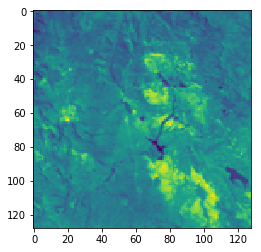

In [76]:
plt.imshow(lr_image, 56, 12, 4, reuse=False)

In [ ]:
prediction = fsrcnn(lr_image, 52, )

In [40]:
traindf['hr'] = traindf['label'].apply(lambda x: get_hr(x[:-7])[0])

In [41]:
import sys

In [42]:
del traindf

In [43]:
trainfile = train_dir + 'train.h5'
labelfile = train_dir + 'label.h5'

In [ ]:
SRCNN.compile(optimizer='adam', loss='MSE', metrics=['mse'])

In [ ]:
class cPSNR(Callback):
    def __init__(self, norm_path = './dataset/probav_data/norm.csv'):
        self.norm = pd.read_csv(norm_path, sep=' ',
                                names=['image', 'cPSNR'],
                                index_col='image')\
                    .T.squeeze()
        
def cPSNR_keras(image_path, sr, norm_path=):
    """function to calculate the clear peak signal to noise rate
    it is the metric used for proba_v conmpetition. This metric uses
    the norm.csv file that contains the baseline cPSNR of image HR"""
    # see https://kelvins.esa.int/proba-v-super-resolution/scoring/
    
    image_id = image_path[-10:]
    # read the file containing the baseline cPSNR
    norm = pd.read_csv(norm_path, sep=' ', names=['image', 'cPSNR'], index_col='image')
    # transform it to pandas Series
    norm = norm.T.squeeze()
    # we crop the HR image so we should also crop th SR image
    sr_crop = sr[3:-3, 3:-3]
    # list individual score of SR for each u, v in {0, 1, ... , 6}
    z = [] 
    hr, sm = get_hr(image_path)
    for u, v in product(range(7), range(7)):
        # crop the image so that its upper left corner at coordinates (u,v)
        # and its lower right corner at (378+u,378+v)
        hr_uv = hr[u:378+u, v:378+v]
        sm_uv = sm[u:378+u, v:378+v]
        b = np.mean(hr_uv[sm_uv] - sr_crop[sm_uv])
        cMSE = np.mean((hr_uv[sm_uv] - sr_crop[sm_uv]-b)**2)
        cPSNR = -10.*np.log10(cMSE)
        z.append(norm[image_id]/cPSNR)
    return np.min(z)        

Data augmentation
transform HR image by resizing them up and down